In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
import utilities

In [3]:
from importlib import reload

In [4]:
reload(utilities)

<module 'utilities' from 'C:\\Users\\luisr\\SharedProjects\\HowToWinKaggle\\FinalProject\\utilities.py'>

In [5]:
sales = utilities.load_and_preprocess()

In [7]:
agg_sales = utilities.aggregate_monthly(sales)

In [9]:
agg_sales.shop_id.value_counts().head()

31    99241
25    87977
54    70471
28    64639
57    59972
Name: shop_id, dtype: int64

In [51]:
shop31 = agg_sales.query('shop_id == 31').copy()
shop31 = shop31.pivot(index='item_id', columns='Month', values='item_cnt_month').fillna(0)

In [52]:
shop31

Month,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
item_id,,,,,,,,,,,,,,,,,,,,,
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,112.0,65.0,13.0,10.0,3.0,4.0,1.0,4.0,2.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22160,1.0,2.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32.0,25.0,7.0,2.0,4.0,4.0,5.0,0.0,1.0
22163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,5.0,6.0


In [53]:
FIT_MONTHS = 24

In [108]:
Xs = []
Ys = []
for i in range(0,9):
    Xs.append(shop31.iloc[:,i:FIT_MONTHS+i].values)
    Ys.append(shop31.iloc[:,FIT_MONTHS+i].values)

In [109]:
Y = np.hstack(Ys)
X = np.row_stack(Xs)

In [110]:
X.shape, Y.shape

((129744, 24), (129744,))

In [112]:
rf = RandomForestRegressor(n_estimators=500, max_depth=5)

In [113]:
fitted_rf = rf.fit(X, Y)

In [119]:
X_test = shop31.iloc[:,-FIT_MONTHS - 1: -1].values
Y_test = shop31.iloc[:,-1].values

In [123]:
y_pred = fitted_rf.predict(X_test)

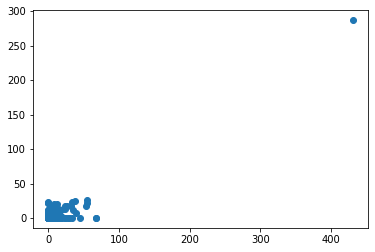

In [126]:
plt.scatter(Y_test, y_pred)

## Create model/pred for each shop independently

In [111]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
FIT_MONTHS = 24

In [144]:
shops = list(agg_sales.shop_id.unique())

In [178]:
def create_windowed_XY(df, fit_cols):
    total_months = df.shape[1]
    total_pred_months = total_months - fit_cols
    if total_pred_months <= 0:
        return (None, None)
    
    Xs = []
    Ys = []
    for i in range(0,total_pred_months):
        Xs.append(single_shop.iloc[:,i:FIT_MONTHS+i].values)
        Ys.append(single_shop.iloc[:,FIT_MONTHS+i].values)

    Y = np.hstack(Ys)
    X = np.row_stack(Xs)
    return X,Y
    

In [185]:
%%time
results = []
for shop_num in shops:
    print('working on shop {}'.format(shop_num))
    
    single_shop = agg_sales.query('shop_id == @shop_num').pivot(index='item_id', columns='Month', values='item_cnt_month').fillna(0)
    X, Y = create_windowed_XY(single_shop, FIT_MONTHS)
    if X is None:
        continue

    rf = RandomForestRegressor(n_estimators=100, max_depth=5)
    fitted_rf = rf.fit(X, Y)

    X_final = single_shop.iloc[:,-FIT_MONTHS:].values
    y_pred = fitted_rf.predict(X_final)

    single_shop_res = pd.DataFrame({'pred':y_pred, 'item_id':single_shop.index, 'shop_id':shop_num})
    results.append(single_shop_res)

working on shop 0
working on shop 1
working on shop 2
working on shop 3
working on shop 4
working on shop 6
working on shop 7
working on shop 8
working on shop 10
working on shop 12
working on shop 13
working on shop 14
working on shop 15
working on shop 16
working on shop 18
working on shop 19
working on shop 21
working on shop 22
working on shop 23
working on shop 24
working on shop 25
working on shop 26
working on shop 27
working on shop 28
working on shop 29
working on shop 30
working on shop 31
working on shop 32
working on shop 35
working on shop 37
working on shop 38
working on shop 41
working on shop 42
working on shop 43
working on shop 44
working on shop 45
working on shop 46
working on shop 47
working on shop 50
working on shop 51
working on shop 52
working on shop 53
working on shop 54
working on shop 56
working on shop 59
working on shop 5
working on shop 57
working on shop 58
working on shop 55
working on shop 17
working on shop 9
working on shop 49
working on shop 39
wor

In [186]:
final_results = pd.concat(results)

In [189]:
test = pd.read_csv('data/test.csv')

In [191]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [190]:
final_results

,pred,item_id,shop_id
0,0.082204,27,2
1,0.082204,30,2
2,0.358458,31,2
3,0.086370,32,2
4,0.318713,33,2
...,...,...,...
1980,0.393249,21995,55
1981,0.227854,22078,55
1982,0.227854,22080,55
1983,0.227854,22165,55


In [199]:
submission = pd.merge(test, final_results, how='left').fillna(0).set_index('ID').pred.rename('item_cnt_month')

In [201]:
submission.to_csv('individual_rf_fit_months_24.csv')

## DO Cross Validation

In [255]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [256]:
reshaped = agg_sales.set_index(['Month','shop_id','item_id']).item_cnt_month.unstack(level=0)

In [257]:
reshaped.shape

(424124, 34)

#### TEST one model per shop vs one model for all

In [258]:
FIT_MONTHS = 24

In [259]:
i = 0

In [260]:
X_train = reshaped.iloc[:,i:i+FIT_MONTHS].fillna(0)
Y_train = reshaped.iloc[:, i+FIT_MONTHS].fillna(0)

In [261]:
X_test = reshaped.iloc[:,i+1:i+FIT_MONTHS+1].fillna(0)
Y_test = reshaped.iloc[:, i+FIT_MONTHS+1].fillna(0)

In [262]:
shops = sorted(reshaped.index.levels[0])

In [270]:
%%time

in_sample_rmse = []
in_sample_sse = []
out_sample_rmse = []
out_sample_sse = []
in_sample_samples = []
out_sample_samples = []

for shop in shops:

    X_train_shop = X_train.loc[shop]
    Y_train_shop = Y_train.loc[shop]
    
    X_test_shop = X_test.loc[shop]
    Y_test_shop = Y_test.loc[shop]

    rf = RandomForestRegressor(n_estimators=100, max_depth=4)
    
    fitted_rf = rf.fit(X_train_shop, Y_train_shop)
    y_train_shop_pred = fitted_rf.predict(X_train_shop)
    
    samples = len(Y_train_shop)
    mse = mean_squared_error(Y_train_shop, y_train_shop_pred)
    sse = mse*samples
    rmse = np.sqrt(mse)

    in_sample_samples.append(samples)
    in_sample_rmse.append(rmse)
    in_sample_sse.append(sse)
    

    y_test_shop_pred = fitted_rf.predict(X_test_shop)
    
    samples = len(Y_test_shop)
    mse = mean_squared_error(Y_test_shop, y_test_shop_pred)
    sse = mse*samples
    rmse = np.sqrt(mse)
    
    out_sample_samples.append(samples)
    out_sample_rmse.append(rmse)
    out_sample_sse.append(sse)
    

Wall time: 23.9 s


In [277]:
errors = pd.DataFrame({'in_sample_rmse':in_sample_rmse, 'in_sample_sse':in_sample_sse, 'in_sample_samples':in_sample_samples, 'out_sample_rmse':out_sample_rmse, 'out_sample_sse':out_sample_sse, 'out_sample_samples':out_sample_samples})

In [278]:
errors[['in_sample_rmse', 'out_sample_rmse']].mean()

in_sample_rmse     0.996087
out_sample_rmse    1.245188
dtype: float64

In [281]:
error_sums = errors[['in_sample_sse', 'in_sample_samples', 'out_sample_sse', 'out_sample_samples']].sum()

In [283]:
np.sqrt(error_sums.in_sample_sse/error_sums.in_sample_samples)

1.6592596680731493

In [284]:
np.sqrt(error_sums.out_sample_sse/error_sums.out_sample_samples)

2.062367670210427

#### Single RF

In [285]:
i = 0
rf = RandomForestRegressor(n_estimators=100, max_depth=4)

In [286]:
%%time
rf_model = rf.fit(X_train,Y_train)

Wall time: 29 s


In [287]:
y_train_pred = rf_model.predict(X_train)

In [288]:
is_rmse = np.sqrt(mean_squared_error(Y_train, y_train_pred))
is_rmse

1.760384071177777

In [289]:
y_test_pred = rf_model.predict(X_test)

In [290]:
os_rmse = np.sqrt(mean_squared_error(Y_test, y_test_pred))
os_rmse

2.2968173294813052

### Multiple models - clipped predictors

In [292]:
%%time

in_sample_rmse = []
in_sample_sse = []
out_sample_rmse = []
out_sample_sse = []
in_sample_samples = []
out_sample_samples = []

for shop in shops:

    X_train_shop = np.clip(X_train.loc[shop], 0, 20)
    Y_train_shop = Y_train.loc[shop]
    
    X_test_shop = np.clip(X_test.loc[shop],0 ,20)
    Y_test_shop = Y_test.loc[shop]

    rf = RandomForestRegressor(n_estimators=100, max_depth=4)
    
    fitted_rf = rf.fit(X_train_shop, Y_train_shop)
    y_train_shop_pred = fitted_rf.predict(X_train_shop)
    
    samples = len(Y_train_shop)
    mse = mean_squared_error(Y_train_shop, y_train_shop_pred)
    sse = mse*samples
    rmse = np.sqrt(mse)

    in_sample_samples.append(samples)
    in_sample_rmse.append(rmse)
    in_sample_sse.append(sse)
    

    y_test_shop_pred = fitted_rf.predict(X_test_shop)
    
    samples = len(Y_test_shop)
    mse = mean_squared_error(Y_test_shop, y_test_shop_pred)
    sse = mse*samples
    rmse = np.sqrt(mse)
    
    out_sample_samples.append(samples)
    out_sample_rmse.append(rmse)
    out_sample_sse.append(sse)
    

Wall time: 24.4 s


In [293]:
errors = pd.DataFrame({'in_sample_rmse':in_sample_rmse, 'in_sample_sse':in_sample_sse, 'in_sample_samples':in_sample_samples, 'out_sample_rmse':out_sample_rmse, 'out_sample_sse':out_sample_sse, 'out_sample_samples':out_sample_samples})

In [294]:
errors[['in_sample_rmse', 'out_sample_rmse']].mean()

in_sample_rmse     1.105263
out_sample_rmse    1.580177
dtype: float64

In [295]:
error_sums = errors[['in_sample_sse', 'in_sample_samples', 'out_sample_sse', 'out_sample_samples']].sum()

In [296]:
np.sqrt(error_sums.in_sample_sse/error_sums.in_sample_samples)

2.0618431909937307

In [297]:
np.sqrt(error_sums.out_sample_sse/error_sums.out_sample_samples)

2.933374456979265

#### Single RF clipped predictors

In [298]:
i = 0
rf = RandomForestRegressor(n_estimators=100, max_depth=4)

In [299]:
X_train_clipped = np.clip(X_train, 0 , 20)
X_test_clipped = np.clip(X_test, 0 ,20)

In [300]:
%%time
rf_model = rf.fit(X_train_clipped,Y_train)

Wall time: 29.2 s


In [301]:
y_train_pred = rf_model.predict(X_train_clipped)

In [302]:
is_rmse = np.sqrt(mean_squared_error(Y_train, y_train_pred))
is_rmse

2.931739904613992

In [303]:
y_test_pred = rf_model.predict(X_test_clipped)

In [304]:
os_rmse = np.sqrt(mean_squared_error(Y_test, y_test_pred))
os_rmse

2.0044993350588003

## Single RF Submission

In [246]:
i = reshaped.shape[1]-25
X_train = reshaped.iloc[:,i:i+FIT_MONTHS].fillna(0)
Y_train = reshaped.iloc[:, i+FIT_MONTHS].fillna(0)
rf = RandomForestRegressor(n_estimators=100, max_depth=4)

In [247]:
%%time
rf_model = rf.fit(X,Y)

Wall time: 28.3 s


In [248]:
y_pred = rf_model.predict(X)

In [249]:
rmse = np.sqrt(mean_squared_error(Y, y_pred))
rmse

1.6902978971798241

In [251]:
i = reshaped.shape[1] - 24
X_final = reshaped.iloc[:,i:i+FIT_MONTHS].fillna(0)
y_pred = rf_model.predict(X_final)
prediction = pd.Series(y_pred, index=X_final.index).rename('pred').reset_index()
submission = utilities.merge_pred_with_test(prediction,pred_col='pred')

In [252]:
submission.to_csv('submissions/jointRF_v1_noClip.csv')

Clipped predictors

In [217]:
i = reshaped.shape[1]-25
X_train = clipped.iloc[:,i:i+FIT_MONTHS].fillna(0)
Y_train = reshaped.iloc[:, i+FIT_MONTHS].fillna(0)
rf = RandomForestRegressor(n_estimators=100, max_depth=4)

In [218]:
%%time
rf_model = rf.fit(X,Y)

Wall time: 28.1 s


In [219]:
y_pred = rf_model.predict(X)

In [221]:
rmse = np.sqrt(mean_squared_error(Y, y_pred))
rmse

In [241]:
i = reshaped.shape[1] - 24
X_final = clipped.iloc[:,i:i+FIT_MONTHS].fillna(0)
y_pred = rf_model.predict(X_final)
prediction = pd.Series(y_pred, index=X_final.index).rename('pred').reset_index()
submission = utilities.merge_pred_with_test(prediction,pred_col='pred')

In [243]:
submission.to_csv('submissions/jointRF_v0.csv')

In [245]:
submission.describe()

count    214200.000000
mean          0.126938
std           0.457021
min           0.000000
25%           0.000000
50%           0.140200
75%           0.140200
max           9.845513
Name: item_cnt_month, dtype: float64

In [73]:
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=33, max_train_size=24)

# for train_idx, test_idx in tscv.split(reshaped):
#     print(train_idx)
#     print(test_idx)

## TODO
* create score from rolling fits
* add shop 'bouginess' score
* add which month is this feature